### 課題3
以下の小問の(1)-(3)を解答すること．(4）は任意回答．

1. 全結合のみ(100, 30, 10)のmodel, 畳み込み(20, 20)＋全結合(10)のmodel2 に関して，全結合と畳み込みの違いをパラメータ数と認識性能の観点から考察せよ．
1. 学習のaccuracy/lossのグラフで青線(training), 赤線(validation)が乖離すると，過学習になっているとみなすことができる．それを解決するために，全結合のみのmodel, 畳み込み＋全結合のmodel2 のそれぞれにDropoutを追加するとどうなるか実験せよ．なお，modelには，2番目の全結合の後に0.2の割合で，model2には2つの畳み込みの直後に割合0.5でそれぞれ挿入せよ.
1. model2に BatchNormalizationを追加せよ．その際，Dropoutを使ったほうがいいか，使わないほうがいいか比較せよ．
1. OptimizerをAdamに変更して，MomentumSDGとの結果の違いを観察せよ．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# カレントディレクトリの読み込みとカレントディレクトリへの移動
import sys
sys.path.append(f'/content/drive/My Drive/system/')
import os
os.chdir(f'/content/drive/My Drive/system/myanswer')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout
import numpy as np
import keras
import keras.datasets

In [ ]:
def generate_data(dataset="mnist", is_conv=True):
    """
    データセットを読み込み，学習データとそのラベル，テストデータとそのラベルを返す関数
    dataset(str): データセットの名前．mnist or fashion_mnist が代入されることが条件
    is_conv(bool): 畳み込み層を使うかどうか
    """
    if dataset == "mnist":
        (x_train, y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
    elif dataset == "fashion_mnist":
        (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
    else:
        raise ValueError("Invalid dataset")
    # 1 of Kのベクトルに変換
    Y_train = keras.utils.to_categorical(y_train, 10)
    Y_test = keras.utils.to_categorical(y_test, 10)
    
    if is_conv == True:
        #[0,255]の値を[0,1]に正規化して，(サンプル数，高さ，幅，チャネル数)に変形
        # 畳み込み層入力用．
        x_train = x_train.reshape(60000,28,28,1).astype('float32') / 255.0
        x_test = x_test.reshape(10000,28,28,1).astype('float32') / 255.0
        
        return x_train, Y_train, x_test, Y_test, y_train, y_test
    
    elif is_conv == False:
        # 28x28の画像を全結合入力用に，784次元にベクトル化．(サンプル数，784次元)
        X_train = x_train.reshape(60000,784).astype('float32')
        X_test = x_test.reshape(10000,784).astype('float32')
        
        return X_train, Y_train, X_test, Y_test, y_train, y_test

In [ ]:
x_train, Y_train, x_test, Y_test, y_train, y_test = generate_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train, _ , X_test, _, _, _ = generate_data(is_conv=False)

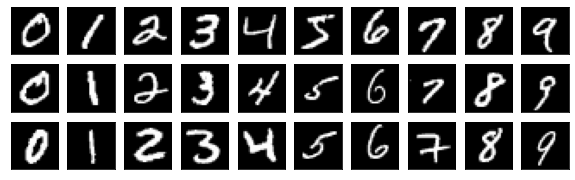

In [ ]:
#MNISTデータの表示
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    idx = y_train ==i %10
    X = X_train[idx]
    ax.imshow(X[i//10].reshape((28, 28)), cmap='gray')

In [ ]:
def fc_model(is_drop=False, optimizer="momentum_sgd"):
    """
    全結合層のみのモデルを生成する関数
    入力
    is_drop(bool): Dropoutを使うかどうか
    optimizer(str): 勾配の最適化方法 momentum_sgd or adam という文字列が入る
    
    出力 全結合層のみのモデル
    """
    if is_drop == True:
        model = Sequential()
        model.add(Dense(100, input_dim=784, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(10, activation='softmax'))
        if optimizer == "momentum_sgd":
            model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9),metrics=["accuracy"])
        elif optimizer == "adam":
            model.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=["accuracy"])
        return model
    
    elif is_drop == False:
        model = Sequential()
        model.add(Dense(100, input_dim=784, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(10, activation='softmax'))
        if optimizer == "momentum_sgd":
            model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9),metrics=["accuracy"])
        elif optimizer == "adam":
            model.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=["accuracy"])
        return model

In [ ]:
def conv_model(is_drop=False, is_batch=False, optimizer="momentum_sgd"):
    """
    畳み込み+全結合層のモデルを生成する関数
    入力
    is_drop(bool): Dropoutを使うかどうか
    is_batch(bool): BatchNormalizationを使うかどうか
    optimizer(str): 勾配の最適化方法 momentum_sgd or adam という文字列が入る
    
    出力 畳み込み + 全結合層のモデル
    """
    if is_drop == False and is_batch == False:
        model2 = Sequential()
        model2.add(Conv2D(20, 3, padding='same', activation='relu', input_shape=(28, 28, 1), kernel_initializer='he_normal'))
        model2.add(MaxPooling2D(pool_size=(2, 2)))
        model2.add(Conv2D(20, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
        model2.add(Flatten()) 
        model2.add(Dense(10, activation='softmax'))
        
        if optimizer == "momentum_sgd":
            model2.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9),metrics=["accuracy"])
        elif optimizer == "adam":
            model2.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=["accuracy"])
        
        return model2
    
    elif is_drop == False and is_batch == True:
        model2 = Sequential()
        model2.add(Conv2D(20, 3, padding='same', activation='relu', input_shape=(28, 28, 1), kernel_initializer='he_normal'))
        model2.add(BatchNormalization())
        model2.add(MaxPooling2D(pool_size=(2, 2)))
        model2.add(Conv2D(20, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
        model2.add(BatchNormalization())
        model2.add(Flatten()) 
        model2.add(Dense(10, activation='softmax'))
        
        if optimizer == "momentum_sgd":
            model2.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9),metrics=["accuracy"])
        elif optimizer == "adam":
            model2.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=["accuracy"])
        
        return model2
    
    elif is_drop == True and is_batch == False:
        model2 = Sequential()
        model2.add(Conv2D(20, 3, padding='same', activation='relu', input_shape=(28, 28, 1), kernel_initializer='he_normal'))
        model2.add(Dropout(0.5))
        model2.add(MaxPooling2D(pool_size=(2, 2)))
        model2.add(Conv2D(20, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
        model2.add(Dropout(0.5))
        model2.add(Flatten()) 
        model2.add(Dense(10, activation='softmax'))
        
        if optimizer == "momentum_sgd":
            model2.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9),metrics=["accuracy"])
        elif optimizer == "adam":
            model2.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=["accuracy"])
        
        return model2
    
    elif is_drop == True and is_batch == True:
        model2 = Sequential()
        model2.add(Conv2D(20, 3, padding='same', activation='relu', input_shape=(28, 28, 1), kernel_initializer='he_normal'))
        model2.add(Dropout(0.5))
        model2.add(BatchNormalization())
        model2.add(MaxPooling2D(pool_size=(2, 2)))
        model2.add(Conv2D(20, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
        model2.add(Dropout(0.5))
        model2.add(BatchNormalization())
        model2.add(Flatten()) 
        model2.add(Dense(10, activation='softmax'))
        
        if optimizer == "momentum_sgd":
            model2.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9),metrics=["accuracy"])
        elif optimizer == "adam":
            model2.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=["accuracy"])
        
        return model2

In [ ]:
# callback のクラス ShowGraphを定義
class ShowGraph(keras.callbacks.Callback):
    def __init__(self,max_epoch, model_name, optimizer, is_drop, is_batch):
        # 表示エリアの設定
        self.fig = plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0.9, 1.0])
        self.fig1.set_title('accuracy')
        self.fig1.set_ylabel('accuracy')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([0, max_epoch, 0, 0.3 ])
        self.fig2.set_title('loss')
        self.fig2.set_ylabel('loss')
        self.fig2.set_xlabel('epoch')
        self.max_epoch = max_epoch
        self.start = time.time()
        self.model_name = model_name
        self.optimizer = optimizer
        self.is_drop = str(is_drop)
        self.is_batch = str(is_batch)
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses = []
        self.losses_val = []
        self.acc = []
        self.acc_val = []
        self.n_epoch = []
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, logs={}):
        self.n_epoch.append(epoch)
        self.acc.append(logs.get('accuracy'))
        self.acc_val.append(logs.get('val_accuracy'))     
        self.losses.append(logs.get('loss'))
        self.losses_val.append(logs.get('val_loss'))     
        self.test_acc = logs.get('val_accuracy')
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
        self.fig1.plot(self.n_epoch,self.acc_val,"r")
        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
        self.fig2.plot(self.n_epoch,self.losses_val,"r")
        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
        
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val acc値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        # 実行結果の画像を保存
        self.fig.savefig("../result/basic_model/result_{}_{}_isdrop_{}_isbatch_{}.png".format(self.model_name, self.optimizer, self.is_drop, self.is_batch),
                         transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.0)
        print("val_acc: {}".format(self.test_acc))
        print('Time: {}'.format(time.time()-self.start))

課題3.1 
全結合のみ(100, 30, 10)のmodel, 畳み込み(20, 20)＋全結合(10)のmodel2 に関して全結合と畳み込みの違いをパラメータ数と認識性能の観点から考察せよ．

考察を書く

課題3.2 
学習のaccuracy/lossのグラフで青線(training), 赤線(validation)が乖離すると，過学習になっているとみなすことができる．

それを解決するために，全結合のみのmodel, 畳み込み＋全結合のmodel2 のそれぞれにDropoutを追加するとどうなるか実験せよ．

なお，modelには，2番目の全結合の後に0.2の割合で，model2には2つの畳み込みの直後に割合0.5でそれぞれ挿入せよ．

* 全結合層のモデルにDropoutを追加

In [ ]:
model_drop = fc_model(is_drop=True)

In [ ]:
num_epoch = 25
batch_size = 200

val_acc: 0.20909999310970306
Time: 25.62040376663208


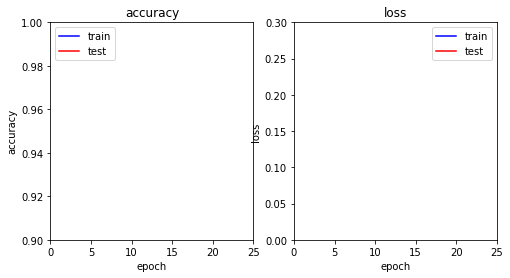

In [ ]:
show_graph = ShowGraph(max_epoch=num_epoch, model_name="fcmodel", optimizer="momentumsgd", is_drop=True, is_batch=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
history = model_drop.fit(X_train, Y_train, epochs=num_epoch+1, validation_data=(X_test,Y_test), batch_size=batch_size, verbose=0, callbacks=[show_graph,reduce_lr])
del show_graph

* 畳み込み層のモデルにDropoutを追加

In [ ]:
model2_drop = conv_model(is_drop=True)

val_acc: 0.989799976348877
Time: 36.08614444732666


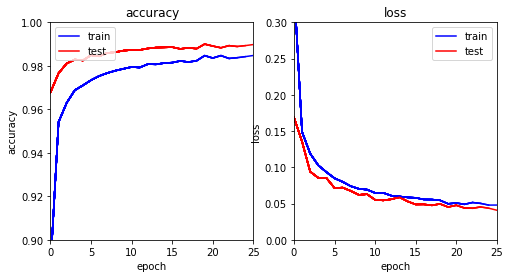

In [ ]:
show_graph2 = ShowGraph(max_epoch=num_epoch, model_name="convmodel", optimizer="momentumsgd", is_drop=True, is_batch=False)
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
history2 = model2_drop.fit(x_train, Y_train, epochs=num_epoch+1, validation_data=(x_test,Y_test), batch_size=batch_size, verbose=0, callbacks=[show_graph2, reduce_lr2])
del show_graph2

課題3.3
model2に BatchNormalizationを追加せよ．その際，Dropoutを使ったほうがいいか，使わないほうがいいか比較せよ．

In [ ]:
model2_without_drop_with_batch = conv_model(is_drop=False, is_batch=True)

val_acc: 0.9884999990463257
Time: 31.551331758499146


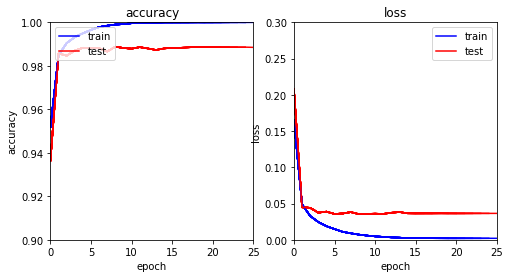

In [ ]:
show_graph2 = ShowGraph(max_epoch=num_epoch, model_name="convmodel", optimizer="momentumsgd", is_drop=False, is_batch=True)
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
history2 = model2_without_drop_with_batch.fit(x_train, Y_train, epochs=num_epoch+1, validation_data=(x_test,Y_test), batch_size=batch_size, verbose=0, callbacks=[show_graph2, reduce_lr2])
del show_graph2

In [ ]:
model2_drop_batch = conv_model(is_drop=True, is_batch=True)

val_acc: 0.9878000020980835
Time: 36.9856698513031


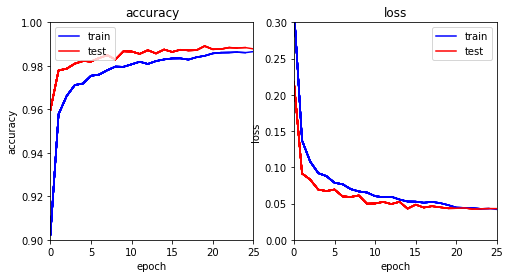

In [ ]:
show_graph2 = ShowGraph(max_epoch=num_epoch, model_name="convmodel", optimizer="momentumsgd", is_drop=True, is_batch=True)
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
history2 = model2_drop_batch.fit(x_train, Y_train, epochs=num_epoch+1, validation_data=(x_test,Y_test), batch_size=batch_size, verbose=0, callbacks=[show_graph2, reduce_lr2])
del show_graph2

課題3 4. OptimizerをAdamに変更して，MomentumSGDとの結果の違いを観察せよ．

簡単のため
* 全結合層のモデルではDropoutを使用しない
* 畳み込み層のモデルではDropoutとBatchNormalizationを使用しない
ものとする．

まずは
* 全結合層のモデルに対してDropoutを使わず，optimizerをMomentumSGDにした場合

の結果を示す．

In [ ]:
model = fc_model()

val_acc: 0.11349999904632568
Time: 21.80917501449585


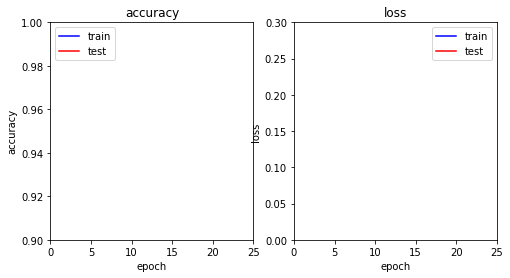

In [ ]:
show_graph = ShowGraph(max_epoch=num_epoch, model_name="fcmodel", optimizer="momentumsgd", is_drop=False, is_batch=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
history = model.fit(X_train, Y_train, epochs=num_epoch+1, validation_data=(X_test,Y_test), batch_size=batch_size, verbose=0, callbacks=[show_graph,reduce_lr])
del show_graph

* 全結合層のモデルに対してoptimizerをAdamにした場合

In [ ]:
model_adam = fc_model(optimizer="adam")

val_acc: 0.9664000272750854
Time: 22.51425075531006


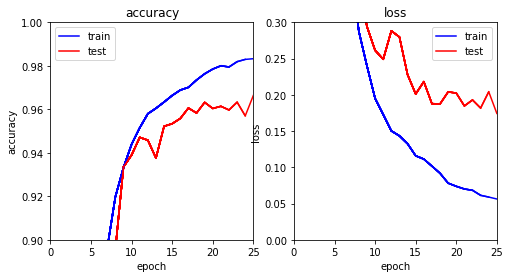

In [ ]:
show_graph = ShowGraph(max_epoch=num_epoch, model_name="fcmodel", optimizer="adam", is_drop=False, is_batch=False)
history = model_adam.fit(X_train, Y_train, epochs=num_epoch+1, validation_data=(X_test,Y_test), batch_size=batch_size, verbose=0, callbacks=[show_graph])
del show_graph

* 畳み込み層のモデルに対してoptimizerをMomentumSGDにした場合

In [ ]:
model2 = conv_model()

val_acc: 0.987500011920929
Time: 26.882010459899902


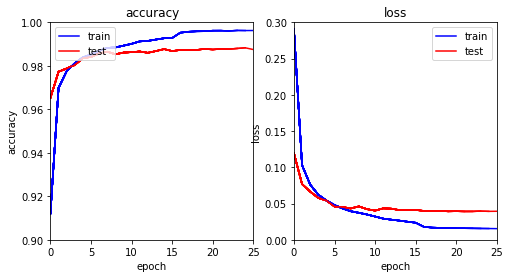

In [ ]:
show_graph2 = ShowGraph(max_epoch=num_epoch, model_name="convmodel", optimizer="momentumsgd", is_drop=False, is_batch=False)
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
history2 = model2.fit(x_train, Y_train, epochs=num_epoch+1, validation_data=(x_test,Y_test), batch_size=batch_size, verbose=0, callbacks=[show_graph2, reduce_lr2])
del show_graph2

* 畳み込み層のモデルに対してoptimizerをAdamにした場合

In [ ]:
model2_adam = conv_model(optimizer="adam")

val_acc: 0.9864000082015991
Time: 26.709465265274048


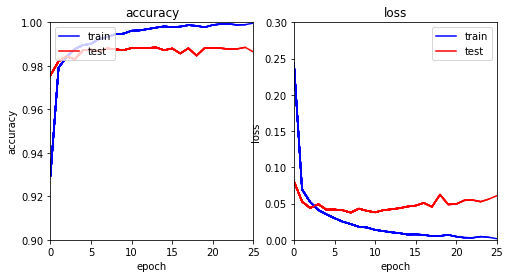

In [ ]:
show_graph2 = ShowGraph(max_epoch=num_epoch, model_name="convmodel", optimizer="adam", is_drop=False, is_batch=False)
history2 = model2_adam.fit(x_train, Y_train, epochs=num_epoch+1, validation_data=(x_test,Y_test), batch_size=batch_size, verbose=0, callbacks=[show_graph2])
del show_graph2